# Download dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd 'drive/MyDrive/Colab Notebooks/DL/HW3'

/content/drive/MyDrive/Colab Notebooks/DL/HW3


In [3]:
# Make data directory if it doesn't exist
!mkdir -p 'Flickr8K'
!wget -nc https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip -P 'Flickr8K'
!unzip -n -d 'Flickr8K' 'Flickr8K/Flickr8k_Dataset.zip'

File ‘Flickr8K/Flickr8k_Dataset.zip’ already there; not retrieving.

Archive:  Flickr8K/Flickr8k_Dataset.zip


In [4]:
!wget -nc https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip -P 'Flickr8K'
!unzip -n -d 'Flickr8K' 'Flickr8K/Flickr8k_text.zip'

File ‘Flickr8K/Flickr8k_text.zip’ already there; not retrieving.

Archive:  Flickr8K/Flickr8k_text.zip


In [5]:
# Download and unzip glove.42B.300d file if it doesn't exist
!wget -nc http://nlp.stanford.edu/data/glove.42B.300d.zip
!unzip -n "glove.42B.300d.zip"

File ‘glove.42B.300d.zip’ already there; not retrieving.

Archive:  glove.42B.300d.zip


In [6]:
! ls ./Flickr8K -all -h

total 1.2G
-rw------- 1 root root 2.8M Oct 14  2013 CrowdFlowerAnnotations.txt
-rw------- 1 root root 8.0M Jan 14 15:51 encoded_test_images.pkl
-rw------- 1 root root  48M Jan 14 15:37 encoded_train_images.pkl
-rw------- 1 root root 339K Oct 14  2013 ExpertAnnotations.txt
drwx------ 2 root root 4.0K Jan 14 12:50 Flicker8k_Dataset
-rw------- 1 root root 1.1G Dec  6 20:59 Flickr8k_Dataset.zip
-rw------- 1 root root  26K Oct 10  2013 Flickr_8k.devImages.txt
-rw------- 1 root root 3.1M Feb 16  2012 Flickr8k.lemma.token.txt
-rw------- 1 root root  26K Oct 10  2013 Flickr_8k.testImages.txt
-rw------- 1 root root 2.3M Dec  6 20:58 Flickr8k_text.zip
-rw------- 1 root root 3.3M Oct 14  2013 Flickr8k.token.txt
-rw------- 1 root root 152K Oct 10  2013 Flickr_8k.trainImages.txt
drwx------ 3 root root 4.0K Jan 14 12:50 __MACOSX
-rw------- 1 root root 1.8K Oct 14  2013 readme.txt


# Import libs

In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer #
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding, concatenate 
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from keras.layers.merge import add
import string
import glob
from time import time
import os
import pickle

# a. Load ids and captions

In [4]:
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

In [5]:
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = list()
		mapping[image_id].append(image_desc)
	return mapping

In [6]:
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

example of on image with id and its five captions.

In [7]:
# load captions
filename = "./Flickr8K/Flickr8k.token.txt"
doc = load_doc(filename)
print(doc[:411])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .



In [8]:
# save data in dictionary structure
descriptions = load_descriptions(doc)
save_descriptions(descriptions, 'descriptions.txt')

In [9]:
pic1_name = list(descriptions.keys())[0]
pic1_name

'1000268201_693b08cb0e'

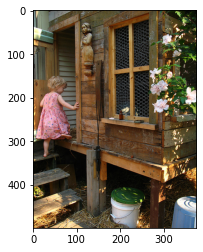

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [10]:
# a sample from dataset
images = './Flickr8K/Flicker8k_Dataset/'
pic = pic1_name
x=plt.imread(images+pic+'.jpg')
plt.imshow(x)
plt.show()

descriptions['1000268201_693b08cb0e']

# b. Clean captions

In [11]:
def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lowercase
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove one character words
			desc = [word for word in desc if len(word)>1]
			# remove words with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

clean_descriptions(descriptions)

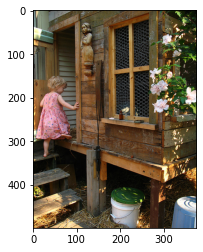

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [12]:
plt.imshow(x)
plt.show()
descriptions['1000268201_693b08cb0e']

# c. Vocabulary

In [13]:
def to_vocabulary(descriptions):
	all_desc = set()
	count = {}
	for key in descriptions.keys():
		[all_desc.update(word.split()) for word in descriptions[key]]
	return all_desc

In [14]:
vocabulary = to_vocabulary(descriptions)
print('Size: %d' % len(vocabulary))

Size: 8763


# d. Train data

In [16]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	for line in doc.split('\n'):
		if len(line) < 1:
			continue
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6000)
filename = './Flickr8K/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [17]:
images = './Flickr8K/Flicker8k_Dataset/'
img = glob.glob(images + '*.jpg')
# train
train_images_file = './Flickr8K/Flickr_8k.trainImages.txt'
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

# test
test_images_file = './Flickr8K/Flickr_8k.testImages.txt'
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [41]:
# load clean captions into memory
def load_clean_descriptions(filename, dataset):
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		image_id, image_desc = tokens[0], tokens[1:]
		if image_id in dataset:
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap caption in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			descriptions[image_id].append(desc)
	return descriptions

# captions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('descriptions: train=%d' % len(train_descriptions))

descriptions: train=6000


In [63]:
len(vocab)

1651

# e. Transfer learning

In [43]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    feature_vec = model_new.predict(image) # Get the encoding vector for the image
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return feature_vec

In [44]:
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x
# Load the inception v3 model
model = InceptionV3(weights='imagenet')
model_new = Model(model.input, model.layers[-2].output)

In [45]:
# Execute this only once
'''
# Call the funtion to encode all the train images

encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)

# Save the bottleneck train features to disk
with open("./Flickr8K/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)
# Call the funtion to encode all the test images - Execute this only once

encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)

# Save the bottleneck test features to disk
with open("./Flickr8K/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)
'''

'\n# Call the funtion to encode all the train images\n\nencoding_train = {}\nfor img in train_img:\n    encoding_train[img[len(images):]] = encode(img)\n\n# Save the bottleneck train features to disk\nwith open("./Flickr8K/encoded_train_images.pkl", "wb") as encoded_pickle:\n    pickle.dump(encoding_train, encoded_pickle)\n# Call the funtion to encode all the test images - Execute this only once\n\nencoding_test = {}\nfor img in test_img:\n    encoding_test[img[len(images):]] = encode(img)\n\n# Save the bottleneck test features to disk\nwith open("./Flickr8K/encoded_test_images.pkl", "wb") as encoded_pickle:\n    pickle.dump(encoding_test, encoded_pickle)\n'

In [46]:
train_features = pickle.load(open("./Flickr8K/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [47]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [49]:
# Consider only words which occur at least 10 times in the corpus
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1
vocab = [w for w in word_counts if word_counts[w] >= 10]

print('before: %d, after: %d' % (len(word_counts), len(vocab)))
print('new vocab:', vocab)

before: 7578, after: 1651
new vocab: ['startseq', 'child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'an', 'way', 'endseq', 'girl', 'going', 'into', 'wooden', 'building', 'little', 'the', 'to', 'her', 'black', 'dog', 'and', 'spotted', 'are', 'fighting', 'tricolored', 'playing', 'with', 'each', 'other', 'on', 'road', 'white', 'brown', 'spots', 'staring', 'at', 'street', 'two', 'dogs', 'different', 'looking', 'pavement', 'moving', 'toward', 'covered', 'paint', 'sits', 'front', 'painted', 'rainbow', 'hands', 'bowl', 'sitting', 'large', 'small', 'grass', 'plays', 'it', 'there', 'pigtails', 'painting', 'young', 'outside', 'man', 'lays', 'bench', 'while', 'his', 'by', 'him', 'which', 'also', 'tied', 'sleeping', 'next', 'shirtless', 'lies', 'park', 'laying', 'holding', 'leash', 'ground', 'orange', 'hat', 'something', 'wears', 'glasses', 'wearing', 'beer', 'can', 'ears', 'rope', 'net', 'red', 'climbs', 'bridge', 'onto', 'ropes', 'playground', 'running', 'grassy', 'g

# f. wordtoix, ixtoword

In [50]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [51]:
vocab_size = len(ixtoword) + 1
vocab_size

1652

In [52]:
# convert a dictionary of clean captions to a list of captions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('max caption Length: %d' % max_length)

max caption Length: 34


# g. Data generator

In [53]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            photo = photos[key+'.jpg']
            for desc in desc_list:
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = list(), list(), list()
                n=0

# h. Glove embedding

In [54]:
# Load Glove vectors
glove_dir = '.'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.42B.300d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 1917494 word vectors.


In [55]:
embedding_dim = 300

# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_matrix.shape

(1652, 300)

# i. Model architecture

In [56]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 300)      495600      ['input_6[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_5[0][0]']                
                                                                                            

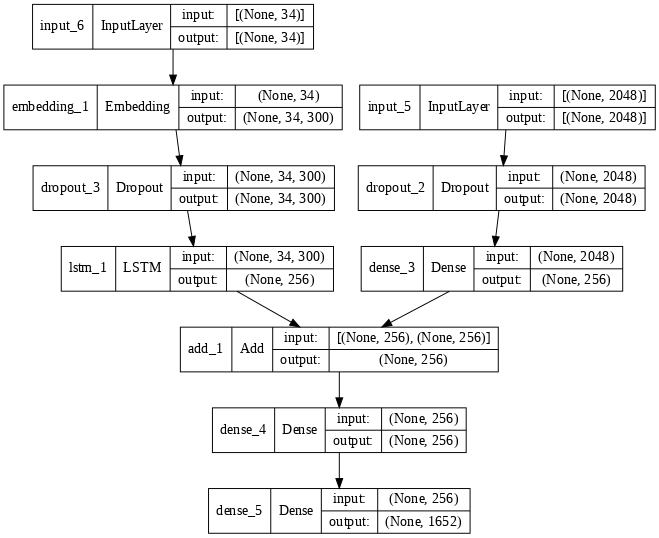

In [57]:
plot_model(model, show_shapes=True, dpi=70)

In [58]:
model.layers[2].set_weights([embedding_matrix])
# freeze embedding layer
model.layers[2].trainable = False

In [59]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [60]:
epochs = 50
number_pics_per_batch = 50
steps = len(train_descriptions)//number_pics_per_batch

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
model.fit_generator(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)
model.save('./model_weights/model_final.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/50
120/120 [==============================] - 29s 214ms/step - loss: 4.9621
Epoch 2/50
120/120 [==============================] - 26s 213ms/step - loss: 3.9262
Epoch 3/50
120/120 [==============================] - 25s 212ms/step - loss: 3.5636
Epoch 4/50
120/120 [==============================] - 25s 212ms/step - loss: 3.3713
Epoch 5/50
120/120 [==============================] - 26s 215ms/step - loss: 3.2455
Epoch 6/50
120/120 [==============================] - 26s 213ms/step - loss: 3.1469
Epoch 7/50
120/120 [==============================] - 25s 211ms/step - loss: 3.0653
Epoch 8/50
120/120 [==============================] - 25s 212ms/step - loss: 2.9967
Epoch 9/50
120/120 [==============================] - 25s 211ms/step - loss: 2.9379
Epoch 10/50
120/120 [==============================] - 25s 212ms/step - loss: 2.8893
Epoch 11/50
120/120 [==============================] - 26s 213ms/step - loss: 2.8446
Epoch 12/50
120/120 [==============================] - 25s 211ms/step - lo

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [39]:
# model.load_weights('./model_weights/model_final.h5')

# j. Test

In [72]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [73]:
images = './Flickr8K/Flicker8k_Dataset/'
with open("./Flickr8K/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

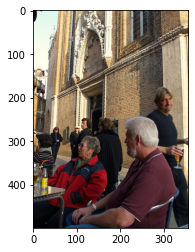

Greedy: group of people sit in front of building


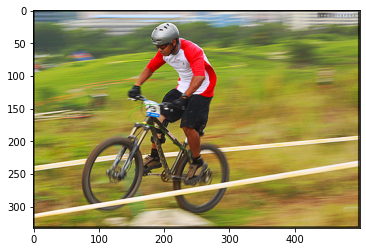

Greedy: man rides his bike down hill


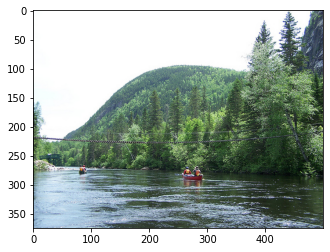

Greedy: two people are wading in natural water


In [77]:
for i in range(3):
  pic = list(encoding_test.keys())[i]
  image1 = encoding_test[pic].reshape((1,2048))
  x=plt.imread(images+pic)
  plt.imshow(x)
  plt.show()
  print("Greedy:",greedySearch(image1))